In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import copy
from astropy.io import ascii
from astropy.table import Table
from scipy.constants import c

import astropy.io.fits as fits
from matplotlib.colors import LogNorm
from astropy.visualization import (
    imshow_norm,
    MinMaxInterval,
    ManualInterval,
    SqrtStretch,
    LogStretch,
    AsinhStretch,
)
from skimage.transform import resize

pd.set_option("display.max_columns", 400)
plt.rcParams.update({"font.size": 16})

## Paths

In [2]:
cat_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/SKIRTOR/3-30SK/"
cat_dirF = "/net/virgo01/data/users/ebbers/BSc_Thesis/Fritz/3-30F/"

COSMOS_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/SKIRTOR/SK3-30/"
COSMOS_dirF= "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/Fritz/F3-30/"

sed_dirSK = cat_dirSK
sed_dirF = cat_dirF

cat_nameSK = "results_3-30SK.fits"
cat_nameF = "results_3-30F.fits"
COSMOS_nameSK = "results_SK3-30.fits"
COSMOS_nameF = 'results_COSMOSF3-30.fits'

observations_fileSK = cat_dirSK + "observations_3-30SK.fits"
observations_fileF = cat_dirF + "observations_3-30F.fits"
COSMOS_observations_fileF = COSMOS_dirF + 'observations_COSMOSF3-30.fits'
COSMOS_observations_fileSK = COSMOS_dirSK + 'observations_SK3-30.fits'

##

#selected_file_Jin = "selected_galaxies_for_SEDs+Jin_Superdeblended.fits"

## Read catalogue and select possible good candidates

Additional criteria:

- $\frac{1}{5} \leq \frac{M_{*, best}}{M_{*, bayes}} \leq 5$

- $\frac{1}{5} \leq \frac{SFR_{best}}{SFR_{bayes}} \leq 5$

- $\frac{1}{5} \leq \frac{f_{AGN, best}}{f_{AGN, bayes}} \leq 5$

- X-ray available in order to have a complete SED

- reduced $\chi^2 < 5$

In [194]:
resultsSK = Table.read(cat_dirSK + cat_nameSK, format="fits").to_pandas()

results_COSMOSSK = Table.read(COSMOS_dirSK + COSMOS_nameSK, format="fits").to_pandas()

resultsSK

,id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.agn.L_6um,bayes.agn.L_6um_err,bayes.agn.accretion_power,bayes.agn.accretion_power_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.agn.torus_dust_luminosity,bayes.agn.torus_dust_luminosity_err,bayes.agn.total_dust_luminosity,bayes.agn.total_dust_luminosity_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.m_star_old,bayes.stellar.m_star_old_err,bayes.stellar.m_star_young,bayes.stellar.m_star_young_err,bayes.PLW,bayes.PLW_err,bayes.PMW,bayes.PMW_err,bayes.PSW,bayes.PSW_err,bayes.WISE1,bayes.WISE1_err,bayes.WISE2,bayes.WISE2_err,bayes.WISE3,bayes.WISE3_err,bayes.WISE4,bayes.WISE4_err,bayes.eROSITA_soft,bayes.eROSITA_soft_err,bayes.herschel.pacs.100,bayes.herschel.pacs.100_err,bayes.herschel.pacs.160,bayes.herschel.pacs.160_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.subaru.hsc.g,bayes.subaru.hsc.g_err,bayes.subaru.hsc.i,bayes.subaru.hsc.i_err,bayes.subaru.hsc.r,bayes.subaru.hsc.r_err,bayes.subaru.hsc.y,bayes.subaru.hsc.y_err,bayes.subaru.hsc.z,bayes.subaru.hsc.z_err,bayes.vista.vircam.H,bayes.vista.vircam.H_err,bayes.vista.vircam.J,bayes.vista.vircam.J_err,bayes.vista.vircam.Ks,bayes.vista.vircam.Ks_err,bayes.vista.vircam.Y,bayes.vista.vircam.Y_err,bayes.vista.vircam.Z,bayes.vista.vircam.Z_err,best.chi_square,best.reduced_chi_square,best.agn.EBV,best.agn.Mcl,best.agn.R,best.agn.delta,best.agn.disk_type,best.agn.emissivity,best.agn.fracAGN,best.agn.i,best.agn.law,best.agn.oa,best.agn.pl,best.agn.q,best.agn.t,best.agn.temperature,best.attenuation.B_B90,best.attenuation.E_BV_factor,best.attenuation.E_BV_lines,best.attenuation.E_BVs,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.dust.alpha,best.dust.gamma,best.dust.qpah,best.dust.umean,best.dust.umin,best.sfh.age,best.sfh.age_burst,best.sfh.age_main,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.xray.E_cut,best.xray.a1,best.xray.a2,best.xray.alpha_ox,best.xray.det_hmxb,best.xray.det_lmxb,best.xray.gam,best.agn.L_6um,best.agn.accretion_power,best.agn.disk_luminosity,best.agn.intrin_Lnu_2500A_30deg,best.agn.luminosity,best.agn.polar_dust_luminosity,best.agn.torus_dust_luminosity,best.agn.total_dust_luminosity,best.dust.luminosity,best.dust.mass,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.xray.agn_Lnu_2keV_30deg,best.xray.agn_Lx_2to10keV,best.xray.agn_Lx_total,best.xray.hmxb_Lx_2to10keV,best.xray.hotgas_Lx_0p5to2keV,best.xray.lmxb_Lx_2to10keV,best.subaru.hsc.g,best.subaru.hsc.r,best.subaru.hsc.i,best.subaru.hsc.z,best.subaru.hsc.y,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.vista.vircam.Z,best.vista.vircam.Y,best.vista.vircam.J,best.vista.vircam.H,best.vista.vircam.Ks,best.WISE1,best.WISE2,best.WISE3,best.WISE4,best.herschel.pacs.100,best.herschel.pacs.160,best.PSW,best.PMW,best.PLW,best.eROSITA_soft
0,42063750055884027,0.129261,0.155234,60.409211,17.077714,59

In [195]:
resultsF = Table.read(cat_dirF + cat_nameF, format="fits").to_pandas()

results_COSMOSF = Table.read(COSMOS_dirF + COSMOS_nameF, format="fits").to_pandas()

resultsF

,id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.psy,bayes.agn.psy_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.agn.accretion_power,bayes.agn.accretion_power_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.agn.torus_dust_luminosity,bayes.agn.torus_dust_luminosity_err,bayes.agn.total_dust_luminosity,bayes.agn.total_dust_luminosity_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.m_star_old,bayes.stellar.m_star_old_err,bayes.stellar.m_star_young,bayes.stellar.m_star_young_err,bayes.PLW,bayes.PLW_err,bayes.PMW,bayes.PMW_err,bayes.PSW,bayes.PSW_err,bayes.WISE1,bayes.WISE1_err,bayes.WISE2,bayes.WISE2_err,bayes.WISE3,bayes.WISE3_err,bayes.WISE4,bayes.WISE4_err,bayes.eROSITA_soft,bayes.eROSITA_soft_err,bayes.herschel.pacs.100,bayes.herschel.pacs.100_err,bayes.herschel.pacs.160,bayes.herschel.pacs.160_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.subaru.hsc.g,bayes.subaru.hsc.g_err,bayes.subaru.hsc.i,bayes.subaru.hsc.i_err,bayes.subaru.hsc.r,bayes.subaru.hsc.r_err,bayes.subaru.hsc.y,bayes.subaru.hsc.y_err,bayes.subaru.hsc.z,bayes.subaru.hsc.z_err,bayes.vista.vircam.H,bayes.vista.vircam.H_err,bayes.vista.vircam.J,bayes.vista.vircam.J_err,bayes.vista.vircam.Ks,bayes.vista.vircam.Ks_err,bayes.vista.vircam.Y,bayes.vista.vircam.Y_err,bayes.vista.vircam.Z,bayes.vista.vircam.Z_err,best.chi_square,best.reduced_chi_square,best.agn.EBV,best.agn.beta,best.agn.delta,best.agn.disk_type,best.agn.emissivity,best.agn.fracAGN,best.agn.gamma,best.agn.law,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.tau,best.agn.temperature,best.attenuation.B_B90,best.attenuation.E_BV_factor,best.attenuation.E_BV_lines,best.attenuation.E_BVs,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.dust.alpha,best.dust.gamma,best.dust.qpah,best.dust.umean,best.dust.umin,best.sfh.age,best.sfh.age_burst,best.sfh.age_main,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.xray.E_cut,best.xray.a1,best.xray.a2,best.xray.alpha_ox,best.xray.det_hmxb,best.xray.det_lmxb,best.xray.gam,best.agn.accretion_power,best.agn.disk_luminosity,best.agn.intrin_Lnu_2500A_30deg,best.agn.luminosity,best.agn.polar_dust_luminosity,best.agn.torus_dust_luminosity,best.agn.total_dust_luminosity,best.dust.luminosity,best.dust.mass,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.xray.agn_Lnu_2keV_30deg,best.xray.agn_Lx_2to10keV,best.xray.agn_Lx_total,best.xray.hmxb_Lx_2to10keV,best.xray.hotgas_Lx_0p5to2keV,best.xray.lmxb_Lx_2to10keV,best.subaru.hsc.g,best.subaru.hsc.r,best.subaru.hsc.i,best.subaru.hsc.z,best.subaru.hsc.y,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.vista.vircam.Z,best.vista.vircam.Y,best.vista.vircam.J,best.vista.vircam.H,best.vista.vircam.Ks,best.WISE1,best.WISE2,best.WISE3,best.WISE4,best.herschel.pacs.100,best.herschel.pacs.160,best.PSW,best.PMW,best.PLW,best.eROSITA_soft
0,42063750055884027,0.336699,0.241687,33.795170,11.582423,5957.796311,834.374604,4889.592214,

In [196]:
useful_cols = [
    "id",
    "best.universe.redshift",
    "bayes.agn.fracAGN",
    "best.agn.fracAGN",
    "bayes.agn.luminosity",
    "best.agn.luminosity",
    "bayes.agn.total_dust_luminosity",
    "best.agn.total_dust_luminosity",
    "best.reduced_chi_square",
    "bayes.stellar.m_star",
    "best.stellar.m_star",
    "bayes.sfh.sfr",
    "best.sfh.sfr",
    "best.universe.luminosity_distance",
    "bayes.sfh.age",
    "best.sfh.age"
]

observations_COSMOSF = Table.read(COSMOS_observations_fileF, format="fits").to_pandas()

df = pd.merge(
    results_COSMOSF[useful_cols],
    observations_COSMOSF,
    on="id",
)
df

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
0,548321.0,0.5842,0.164919,0.00,7.472285e+35,0.000000e+00,7.396822e+35,0.000000e+00,4.434224,1.597643e+09,1.628235e+09,0.601519,0.612824,1.060448e+26,1000.000000,1000.0,0.5842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000010,0.000005,0.000013,0.000004,0.000092,0.000010,0.000386,0.000039,0.000946,0.000095,0.001405,0.000141,0.001787,0.000179,0.000036,0.000899,0.001868,0.000187,0.002510,0.000251,0.003199,0.000320,0.004037,0.000404,0.003014,0.000302,0.001857,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000014,0.000013,0.000044,0.000021,0.000072,0.000014,0.000075,0.000020,0.000116,0.000016,0.000124,0.000023,0.000321,0.000035,0.000695,0.000073,0.000713,0.000073,0.000723,0.000075,0.000938,0.000098,0.001023,0.000105,0.000738,0.000079,0.000967,0.000098,0.002146,0.000218
1,548356.0,0.9276,0.381658,0.99,6.271299e+35,2.583091e+36,6.150815e+35,2.519189e+36,3.281133,2.059803e+08,2.059670e+08,0.078739,0.077575,1.877505e+26,1000.128102,1000.0,0.9276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000052,0.000006,0.000066,0.000008,0.000048,0.000006,0.000070,0.000008,0.000131,0.000014,0.000173,0.000018,0.000230,0.000027,0.000021,0.000102,0.000224,0.000034,0.000148,0.000031,0.000214,0.000042,0.000296,0.000040,0.000227,0.000025,0.000151,0.000019,0.002420,0.000409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000069,0.000013,0.000048,0.000017,0.000063,0.000012,0.000011,0.000014,0.000028,0.000010,NaN,NaN,0.000060,0.000014,0.000100,0.000019,0.000055,0.000013,0.000165,0.000024,0.000134,0.000026,0.000144,0.000027,0.000142,0.000027,0.000157,0.000021,NaN,NaN
2,548417.0,0.8606,0.633714,0.70,6.056719e+37,6.958466e+37,5.996627e+37,6.895312e+37,1.722973,8.648320e+10,8.469629e+10,12.104493,9.903400,1.710206e+26,2301.293980,2000.0,0.8606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000488,0.000095,0.001037,0.000104,0.001039,0.000104,0.001706,0.000171,0.003720,0.000372,0.009231,0.000923,0.015025,0.001503,0.018730,0.001873,0.000097,0.010728,0.020113,0.002012,0.030075,0.003008,0.041910,0.004192,0.064534,0.006454,0.075763,0.007576,0.055586,0.005559,0.052012,0.005232,0.036526,0.003707,0.298436,

In [197]:
mass_ratio = df["best.stellar.m_star"] / df["bayes.stellar.m_star"]
sfr_ratio = df["best.sfh.sfr"] / df["bayes.sfh.sfr"]
fagn_ratio = df["best.agn.fracAGN"] / df["bayes.agn.fracAGN"]

mass_sel = (mass_ratio >= 1 / 5) & (mass_ratio <= 5)
sfr_sel = (sfr_ratio >= 1 / 5) & (sfr_ratio <= 5)
fagn_sel = (fagn_ratio >= 1 / 5) & (fagn_ratio <= 5) 

chi_sel = df["best.reduced_chi_square"] < 5
selection = mass_sel & sfr_sel & fagn_sel & chi_sel

In [198]:
fin_df = df[selection]
fin_df

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
1,548356.0,0.9276,0.381658,0.99,6.271299e+35,2.583091e+36,6.150815e+35,2.519189e+36,3.281133,2.059803e+08,2.059670e+08,0.078739,0.077575,1.877505e+26,1000.128102,1000.0,0.9276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000052,0.000006,0.000066,0.000008,0.000048,0.000006,0.000070,0.000008,0.000131,0.000014,0.000173,0.000018,0.000230,0.000027,0.000021,0.000102,0.000224,0.000034,0.000148,0.000031,0.000214,0.000042,0.000296,0.000040,0.000227,0.000025,0.000151,0.000019,0.002420,0.000409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000069,0.000013,0.000048,0.000017,0.000063,0.000012,0.000011,0.000014,0.000028,0.000010,NaN,NaN,0.000060,0.000014,0.000100,0.000019,0.000055,0.000013,0.000165,0.000024,0.000134,0.000026,0.000144,0.000027,0.000142,0.000027,0.000157,0.000021,NaN,NaN
2,548417.0,0.8606,0.633714,0.70,6.056719e+37,6.958466e+37,5.996627e+37,6.895312e+37,1.722973,8.648320e+10,8.469629e+10,12.104493,9.903400,1.710206e+26,2301.293980,2000.0,0.8606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000488,0.000095,0.001037,0.000104,0.001039,0.000104,0.001706,0.000171,0.003720,0.000372,0.009231,0.000923,0.015025,0.001503,0.018730,0.001873,0.000097,0.010728,0.020113,0.002012,0.030075,0.003008,0.041910,0.004192,0.064534,0.006454,0.075763,0.007576,0.055586,0.005559,0.052012,0.005232,0.036526,0.003707,0.298436,0.030657,3.12083,1.320542,3.5,-1.75,NaN,NaN,NaN,NaN,NaN,NaN,0.001107,0.000112,0.001547,0.000157,0.001636,0.000165,0.001803,0.000183,0.001849,0.000186,0.002701,0.000271,0.003482,0.000349,0.004975,0.000498,0.005851,0.000586,0.007206,0.000721,0.009062,0.000907,0.011432,0.001144,0.006095,0.000612,0.010406,0.001041,NaN,NaN
10,548714.0,0.9374,0.556118,0.55,2.859210e+36,1.553006e+36,2.758937e+36,1.471028e+36,2.061677,1.102949e+09,1.188579e+09,3.014882,1.735497,1.902256e+26,1012.502157,1000.0,0.9374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000182,0.000066,0.000368,0.000037,0.000349,0.000035,0.000414,0.000042,0.000558,0.000056,0.000898,0.000090,0.001190,0.000119,0.001504,0.000152,0.000047,0.000805,0.001424,0.000145,0.001628,0.000165,0.001582,0.000162,0.001814,0.000184,0.001719,0.000172,0.001211,0.000122,0.0

In [199]:
fin_df.loc[fin_df["best.reduced_chi_square"] == 3.999917228366584] 

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
56687,622372.0,1.7104,0.417704,0.99,4.906106e+36,1.283272e+37,4.763781e+36,1.215532e+37,3.999917,3.027643e+08,3.021110e+08,0.777011,0.441126,4.026766e+26,1426.184841,1000.0,1.7104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000081,0.000009,0.000062,0.000007,0.000054,0.000006,0.000078,0.000009,0.000056,0.000007,0.00006,0.000009,0.00002,0.000015,0.000013,0.000074,0.000117,0.000015,0.0001,0.000014,0.000242,0.000027,0.00012,0.000022,0.000173,0.000021,0.000138,0.000018,0.001974,0.000537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000019,0.000038,0.00001,0.000084,0.000016,0.000058,0.00001,0.000091,0.000021,0.000071,0.000013,0.000032,0.000021,0.000079,0.000016,0.000064,0.000018,0.000049,0.000023,NaN,NaN,NaN,NaN,0.000113,0.000019,0.000347,0.000053


In [229]:
min(df["best.reduced_chi_square"])

sel = (df["best.reduced_chi_square"] > 45) & (df["best.reduced_chi_square"] < 47)

display(df[sel])

display(df[df["best.reduced_chi_square"].isin([max(df["best.reduced_chi_square"])])])

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
3635,692040.0,0.8151,0.000397,0.0,1.165209e+34,0.0,1.148120e+34,0.0,45.315783,1.011074e+11,9.862327e+10,12.249108,11.877864,1.598584e+26,4268.561809,4000.0,0.8151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.000033,0.000792,0.000083,0.00387,0.000389,0.012475,0.001248,0.021707,0.002172,0.021565,0.00216,0.000024,0.000159,0.018989,0.0019,0.028863,0.002888,0.031657,0.003168,0.036421,0.003647,0.080957,0.008096,0.050575,0.005058,0.049859,0.005353,0.021909,0.003032,0.02,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000051,0.000106,0.000918,0.000126,0.000277,0.000116,0.001769,0.000196,NaN,NaN,0.003864,0.000402,0.003079,0.000331,0.004332,0.000446,0.005841,0.000602,0.009068,0.000922,0.013701,0.001377,0.004339,0.000496,0.01529,0.001534,0.027839,0.002806


,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
4469,726584.0,0.5516,0.000032,0.0,5.074145e+31,0.0,5.028091e+31,0.0,47.055778,1.618344e+09,1.619753e+09,0.60931,0.609632,9.887625e+25,1000.0,1000.0,0.5516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000072,0.000009,0.000101,0.000011,0.000793,0.000079,0.002692,0.000269,0.007439,0.000744,0.010679,0.001068,0.013114,0.001311,0.000029,0.0074,0.013673,0.001368,0.015783,0.001579,0.016413,0.001642,0.014109,0.001411,0.005999,0.0006,0.004425,0.000443,0.000598,0.000153,0.000504,0.000256,0.02,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000181,0.000021,0.000519,0.000056,0.00079,0.00008,0.000853,0.000086,0.001304,0.000131,0.002005,0.000201,0.002206,0.000221,0.004115,0.000412,0.004291,0.000429,0.006099,0.00061,0.007041,0.000705,0.008878,0.000888,0.00509,0.00051,0.008055,0.000806,NaN,NaN


In [216]:
cols = list(df.columns)
cols[17::2]

['xray_boxcar_0p5to10keV',
 'xray_boxcar_0p5to2keV',
 'xray_boxcar_2to10keV',
 'galex.FUV',
 'galex.NUV',
 'cfht.megacam.u',
 'CFHT_u',
 'subaru.hsc.g',
 'subaru.hsc.r',
 'subaru.hsc.i',
 'subaru.hsc.z',
 'subaru.hsc.y',
 'hst.wfc.F814W',
 'vista.vircam.Y',
 'vista.vircam.J',
 'vista.vircam.H',
 'vista.vircam.Ks',
 'spitzer.irac.ch1',
 'spitzer.irac.ch2',
 'spitzer.irac.ch3',
 'spitzer.irac.ch4',
 'spitzer.mips.24',
 'herschel.pacs.100',
 'herschel.pacs.160',
 'PSW',
 'PMW',
 'PLW',
 'subaru.suprime.IB427',
 'subaru.suprime.IB464',
 'subaru.suprime.IA484',
 'subaru.suprime.IB505',
 'subaru.suprime.IA527',
 'subaru.suprime.IB574',
 'subaru.suprime.IA624',
 'subaru.suprime.IA679',
 'subaru.suprime.IB709',
 'subaru.suprime.IA738',
 'subaru.suprime.IA767',
 'subaru.suprime.IB827',
 'subaru.suprime.NB711',
 'subaru.suprime.NB816',
 'vista.vircam.NB118']

In [8]:
## in um

# COSMOS2020 filters + Spitzer, PACS and SPIRE
wavelengths = np.array([
    2.3616e-4, #xray_0.5-10
    9.9187e-4, #xray_0.5-2
    2.0664e-4, #xray_2-10
    0.1526, #galex_FUV
    0.2307, #galex_NUV
    0.3709, #cfht.megacam
    0.3858, #CFHT_u
    0.4847, #subaru.hsc.g
    0.6219, #.r
    0.7699, #.i
    0.8894, #.z
    0.9761, #.y
    0.8333, #hst.wfc.F814W
    1.0216, #vista.vircam.Y
    1.2525, #.J
    1.6466, #.H
    2.1557, #.Ks
    3.5, #spitzer.irac.ch1
    4.5, #.ch2
    5.8, # .ch3
    8, # .ch4
    24, # spitzer.mips.24
    100, # herschel.pacs.100
    160, #.160
    250, #PSW
    350, #PMW
    500, #PLW
    0.4266, #subaru.suprime.IB427
    0.4635, #subaru.suprime.IB464
    0.4835, #subaru.suprime.IB484
    0.5064, #subaru.suprime.IB505
    0.527, #subaru.suprime.IA527
    0.5766, #subaru.suprime.IB574
    0.624, #subaru.suprime.IB624
    0.679, #subaru.suprime.IB679
    0.7073, #subaru.suprime.IB709
    0.738, #subaru.suprime.IB738
    0.767, #subaru.suprime.IB767
    0.8243, #subaru.suprime.IB827
    0.7121, #subaru.suprime.NB711
    0.8150, #subaru.suprime.NB816
    1.1909, #vista.vircam.NB118
])

# GAMA filters
# wavelengths = np.array([
#     0.4847, #subaru.hsc.g
#     0.6219, #.r
#     0.7699, #.i
#     0.8894, #.z
#     0.9761, #.y
#     0.355, #sdss.u
#     0.470, #sdss.g
#     0.617, #sdss.r
#     0.748, #sdss.i
#     0.876, #vista.vircam.Z
#     1.0216, #vista.vircam.Y
#     1.2525, #.J
#     1.6466, #.H
#     2.1557, #.Ks
#     3.4, #W1
#     4.6, #W2
#     12, #W3
#     22, #W4
#     100, # herschel.pacs.100
#     160, #.160
#     250, #PSW
#     350, #PMW
#     500, #PLW
#     10**(-3), #eROSITA
# ])

# print(len(wavelengths))

ids = [622372.0,
     1068.0,
     2155.0,
     2162.0,
     964356.0,
     964362.0,
     964384.0]

id = [692040.0]

42


In [231]:
display(df[df["id"].isin(id)])

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
3635,692040.0,0.8151,0.000397,0.0,1.165209e+34,0.0,1.148120e+34,0.0,45.315783,1.011074e+11,9.862327e+10,12.249108,11.877864,1.598584e+26,4268.561809,4000.0,0.8151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.000033,0.000792,0.000083,0.00387,0.000389,0.012475,0.001248,0.021707,0.002172,0.021565,0.00216,0.000024,0.000159,0.018989,0.0019,0.028863,0.002888,0.031657,0.003168,0.036421,0.003647,0.080957,0.008096,0.050575,0.005058,0.049859,0.005353,0.021909,0.003032,0.02,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000051,0.000106,0.000918,0.000126,0.000277,0.000116,0.001769,0.000196,NaN,NaN,0.003864,0.000402,0.003079,0.000331,0.004332,0.000446,0.005841,0.000602,0.009068,0.000922,0.013701,0.001377,0.004339,0.000496,0.01529,0.001534,0.027839,0.002806


In [232]:
galaxy = df[df["id"].isin(id)].index[0]
galaxy

3635

## Choose the galaxy to plot

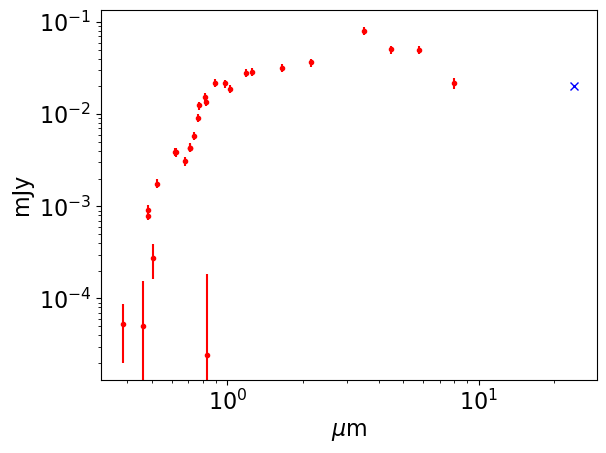

In [233]:
idx = 0
for name, name_err in zip(cols[17:][::2], cols[18:][::2]):
    if df[name_err][galaxy] < 0:
        plt.errorbar(
            wavelengths[idx],
            df[name][galaxy],
            fmt="x",
            color="b",
        )
    else:
        plt.errorbar(
            wavelengths[idx],
            df[name][galaxy],
            yerr=df[name_err][galaxy],
            fmt=".",
            color="r",
        )

    idx += 1

plt.ylabel("mJy")
plt.xlabel("$\mu$m")
plt.xscale("log")
plt.yscale("log")

plt.show()

## Reading the best SED file

In [234]:
z = df["best.universe.redshift"][galaxy]


best_sed_file = COSMOS_dirF + str(id[0]) + "_best_model.fits"



In [235]:
sed = Table.read(best_sed_file, format="fits")
sed

wavelength,Fnu,L_lambda_total,stellar.old,stellar.young,attenuation.stellar.old,attenuation.stellar.young,dust.Umin_Umin,dust.Umin_Umax,agn.fritz2006_torus,agn.fritz2006_polar_dust,agn.fritz2006_disk,xray.galaxy,xray.agn,igm
nm,mJy,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0018151000000000003,1.6077044084878704e-16,4.697930922514e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697930922514334e+31,0.0,-3.3432964411735803e+18
0.001830645534153318,1.795212482527375e-16,5.157139462128818e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.157139462129193e+31,0.0,-3.75597718167059e+18
0.0018463242089777373,2.0028001557584496e-16,5.656180051130798e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.6561800511312185e+31,0.0,-4.219905529856603e+18
0.0018621371647646147,2.2324141812240736e-16,6.198020017239943e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1980200172404155e+31,0.0,-4.734254956796808e+18
0.0018780855515714086,2.486168722023694e-16,6.785805272045642e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.785805272046173e+31,0.0,-5.303765106568498e+18
0.001894170529305313,2.766357707440344e-16,7.42286775765954e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4228677576601345e+31,0.0,-5.941788897870733e+18
0.0019103932678076127,3.0754679251079844e-16,8.112732973389852e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.112732973390517e+31,0.0,-6.647123889494068e+18
0.0019267549469387767,3.416192879539603e-16,8.859127566908017e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.85912756690876e+31,0.0,-7.435719196572403e+18


In [236]:
wavelength_spec = sed["wavelength"] * 1e-3

obj_res = df.loc[df["id"].isin(id)]
obj_obs = df.loc[df["id"].isin(id)]

logwav = np.log(wavelength_spec)
dlam = logwav[1:]-logwav[:-1]

print(dlam[:1020])
print(np.argmax(dlam[:3106]), min(dlam[:3106]))

wavelength_spec[1938]

      wavelength      
          nm          
----------------------
   0.00852809293701462
  0.008528092937016396
   0.00852809293701462
   0.00852809293701462
   0.00852809293701462
   0.00852809293701462
  0.008528092937016396
   0.00852809293701462
   0.00852809293701462
   0.00852809293701462
                   ...
  0.008528092937015508
   0.00852809293701462
2.5471937989962612e-05
   0.11503029227624317
   0.05770166933648557
   0.11499998988238236
   0.11520268979031911
   0.11512730684907702
   0.07837742835447514
   0.03243527575315408
Length = 1020 rows
1016 1.801177824667377e-05


3.0221415

In [237]:
surf = 4.0 * np.pi * float(obj_res["best.universe.luminosity_distance"]) ** 2

k_corr_SED = 1.0
fact = 1e29 * 1e-3 * wavelength_spec**2 / c / surf
for cname in sed.colnames[1:]:
    sed[cname] *= fact

/var/lib/condor/execute/dir_5513/ipykernel_12898/946459365.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  surf = 4.0 * np.pi * float(obj_res["best.universe.luminosity_distance"]) ** 2


In [238]:
xmin, xmax = 1e-4, 1e3

wsed = np.where((wavelength_spec > xmin) & (wavelength_spec < xmax))

In [239]:
obj_res

,id,best.universe.redshift,bayes.agn.fracAGN,best.agn.fracAGN,bayes.agn.luminosity,best.agn.luminosity,bayes.agn.total_dust_luminosity,best.agn.total_dust_luminosity,best.reduced_chi_square,bayes.stellar.m_star,best.stellar.m_star,bayes.sfh.sfr,best.sfh.sfr,best.universe.luminosity_distance,bayes.sfh.age,best.sfh.age,redshift,xray_boxcar_0p5to10keV,xray_boxcar_0p5to10keV_err,xray_boxcar_0p5to2keV,xray_boxcar_0p5to2keV_err,xray_boxcar_2to10keV,xray_boxcar_2to10keV_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,CFHT_u,CFHT_u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,subaru.hsc.y,subaru.hsc.y_err,hst.wfc.F814W,hst.wfc.F814W_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,herschel.pacs.100,herschel.pacs.100_err,herschel.pacs.160,herschel.pacs.160_err,PSW,PSW_err,PMW,PMW_err,PLW,PLW_err,subaru.suprime.IB427,subaru.suprime.IB427_err,subaru.suprime.IB464,subaru.suprime.IB464_err,subaru.suprime.IA484,subaru.suprime.IA484_err,subaru.suprime.IB505,subaru.suprime.IB505_err,subaru.suprime.IA527,subaru.suprime.IA527_err,subaru.suprime.IB574,subaru.suprime.IB574_err,subaru.suprime.IA624,subaru.suprime.IA624_err,subaru.suprime.IA679,subaru.suprime.IA679_err,subaru.suprime.IB709,subaru.suprime.IB709_err,subaru.suprime.IA738,subaru.suprime.IA738_err,subaru.suprime.IA767,subaru.suprime.IA767_err,subaru.suprime.IB827,subaru.suprime.IB827_err,subaru.suprime.NB711,subaru.suprime.NB711_err,subaru.suprime.NB816,subaru.suprime.NB816_err,vista.vircam.NB118,vista.vircam.NB118_err
3635,692040.0,0.8151,0.000397,0.0,1.165209e+34,0.0,1.148120e+34,0.0,45.315783,1.011074e+11,9.862327e+10,12.249108,11.877864,1.598584e+26,4268.561809,4000.0,0.8151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.000033,0.000792,0.000083,0.00387,0.000389,0.012475,0.001248,0.021707,0.002172,0.021565,0.00216,0.000024,0.000159,0.018989,0.0019,0.028863,0.002888,0.031657,0.003168,0.036421,0.003647,0.080957,0.008096,0.050575,0.005058,0.049859,0.005353,0.021909,0.003032,0.02,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000051,0.000106,0.000918,0.000126,0.000277,0.000116,0.001769,0.000196,NaN,NaN,0.003864,0.000402,0.003079,0.000331,0.004332,0.000446,0.005841,0.000602,0.009068,0.000922,0.013701,0.001377,0.004339,0.000496,0.01529,0.001534,0.027839,0.002806


/var/lib/condor/execute/dir_5513/ipykernel_12898/3220104988.py:112: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z = np.round(float(obj_obs["best.universe.redshift"]), 2)
/var/lib/condor/execute/dir_5513/ipykernel_12898/3220104988.py:113: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  chi = np.round(float(obj_res["best.reduced_chi_square"]), 2)
/var/lib/condor/execute/dir_5513/ipykernel_12898/3220104988.py:114: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fagn = np.round(float(obj_res["bayes.agn.fracAGN"]), 2)


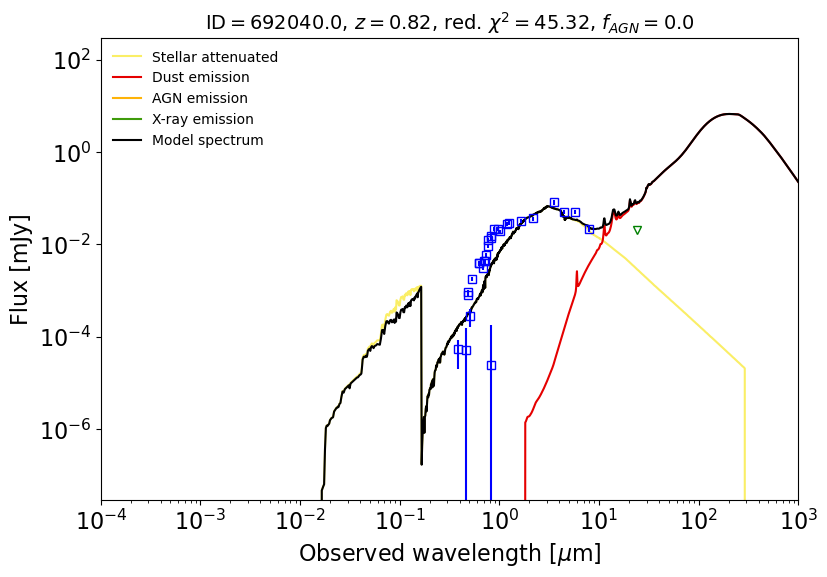

In [240]:
# Create the log-log scale plot
fig, ax1 = plt.subplots(figsize=(9, 6))

# Add spectrum
spectrum = sed["stellar.young"][wsed] + sed["stellar.old"][wsed]
spectrum += sed["attenuation.stellar.young"][wsed]
spectrum += sed["attenuation.stellar.old"][wsed]

ax1.loglog(
    wavelength_spec[wsed],
    spectrum,
    label="Stellar attenuated",
    color="xkcd:yellowish",
    marker=None,
    nonpositive="clip",
    linestyle="-",
    linewidth=1.5,
)

ax1.loglog(
    wavelength_spec[wsed],
    (sed["dust.Umin_Umin"][wsed] + sed["dust.Umin_Umax"][wsed]),
    label="Dust emission",
    color="xkcd:red",
    marker=None,
    nonpositive="clip",
    linestyle="-",
    linewidth=1.5,
)

# Fritz model
agn_sed = (
    sed["agn.fritz2006_polar_dust"]
    + sed["agn.fritz2006_torus"]
    + sed["agn.fritz2006_disk"]
)

# # SKIRTOR model
# agn_sed = (
#     sed["agn.SKIRTOR2016_polar_dust"]
#     + sed["agn.SKIRTOR2016_torus"]
#     + sed["agn.SKIRTOR2016_disk"]
# )

ax1.loglog(
    wavelength_spec[wsed],
    agn_sed[wsed],
    label="AGN emission",
    color="xkcd:amber",
    marker=None,
    nonpositive="clip",
    linestyle="-",
    linewidth=1.5,
)

xray_sed = sed["xray.galaxy"] + sed["xray.agn"]
ax1.loglog(
    wavelength_spec[wsed],
    xray_sed[wsed],
    label="X-ray emission",
    color="xkcd:grass green",
    marker=None,
    nonpositive="clip",
    linestyle="-",
    linewidth=1.5,
)

ax1.loglog(
    wavelength_spec[wsed],
    sed["L_lambda_total"][wsed],
    label="Model spectrum",
    color="k",
    nonpositive="clip",
    linestyle="-",
    linewidth=1.5,
)

idx = 0
for name, name_err in zip(cols[17:][::2], cols[18:][::2]):
    if df[name_err][galaxy] < 0:
        plt.errorbar(
            wavelengths[idx],
            df[name][galaxy],
            fmt="vg",
            fillstyle="none",
        )
        # idx += 1
    else:
        plt.errorbar(
            wavelengths[idx],
            df[name][galaxy],
            yerr=df[name_err][galaxy],
            fmt="sb",
            fillstyle="none",
        )

    idx += 1

fir_wavelengths = [24, 100, 160, 250, 350, 500]
# plt.errorbar(
#     fir_wavelengths,
#     fin_df[jin_cols[:-1][::2]].iloc[galaxy],
#     yerr=fin_df[jin_cols[1:][::2]].iloc[galaxy],
#     fmt="*m",
#     fillstyle="none",
#     label="Jin et al. (2018)",
# )


plt.xlim(xmin, xmax)
plt.ylim(3e-8, 3e2)
plt.legend(fontsize=10, loc="upper left", frameon=False)

z = np.round(float(obj_obs["best.universe.redshift"]), 2)
chi = np.round(float(obj_res["best.reduced_chi_square"]), 2)
fagn = np.round(float(obj_res["bayes.agn.fracAGN"]), 2)


plt.title(
    "ID$=$"
    + str(id[0])
    + ", $z=$"
    + str(z)
    + ", red. $\chi^2=$"
    + str(chi)
    + ", $f_{AGN}=$"
    + str(fagn),
    fontsize=14,
)

plt.xlabel("Observed wavelength [$\mu$m]")
plt.ylabel("Flux [mJy]")

# Define the inset axes for the image overlay
#axins = inset_axes(
    #ax1,
    #width="30%",
    #height="30%",
    #loc="upper center",
#)

# Overlay the image onto the log-log plot
#axins.imshow(image_data, cmap="viridis", norm=norm, origin="lower")
#axins.set_xticks([])
#axins.set_yticks([])

# plt.savefig(
#     plot_dir + "SED_" + str(id[0]) + ".pdf",
#     bbox_inches="tight",
# )
# + "with Superdeblended/"

plt.show()